In [1]:
# Data manipulation
import csv 
import pandas as pd
import numpy as np
import os
import textract
import PyPDF2

# NLP
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import PhraseMatcher
import re
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore") #ignore warning 

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
from joblib import dump, load 

# Resume parser
from pyresparser import ResumeParser

[nltk_data] Downloading package stopwords to C:\Users\Ziad
[nltk_data]     Elhady\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Gender,Age,openness,neuroticism,conscientiousness,agreeableness,extraversion,Personality (Class label)
0,Male,17,7,4,7,3,2,extraverted
1,Male,19,4,5,4,6,6,serious
2,Female,18,7,6,4,5,5,dependable
3,Female,22,5,6,7,4,3,extraverted
4,Female,19,7,4,6,5,4,lively


# **EDA**

In [4]:
df.describe()

,Age,openness,neuroticism,conscientiousness,agreeableness,extraversion
count,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,19.685472,5.019746,4.647391,4.643159,4.827927,4.409027
std,2.510672,1.519052,1.658673,1.703569,1.632564,1.567404
min,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,18.000000,4.000000,4.000000,3.000000,4.000000,3.000000
50%,19.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,21.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,28.000000,8.000000,8.000000,8.000000,8.000000,7.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Gender                     709 non-null    object
 1   Age                        709 non-null    int64 
 2   openness                   709 non-null    int64 
 3   neuroticism                709 non-null    int64 
 4   conscientiousness          709 non-null    int64 
 5   agreeableness              709 non-null    int64 
 6   extraversion               709 non-null    int64 
 7   Personality (Class label)  709 non-null    object
dtypes: int64(6), object(2)
memory usage: 44.4+ KB


This DataFrame profiles 709 people across 8 telling traits - from gender and age to core personality scores for openness, neuroticism and more. With complete data, these 709 rows paint a rich picture of human personality, ready for analysis.

Text(0, 0.5, 'Count')

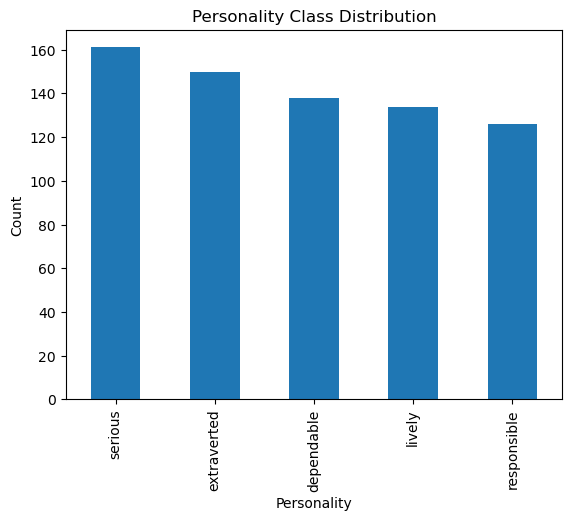

In [6]:
df['Personality (Class label)'].value_counts().plot(kind='bar')
plt.title('Personality Class Distribution')
plt.xlabel('Personality')
plt.ylabel('Count')

It looks that our classes is a little imbalanced

# **Lets plot and see some correlation**


Text(0.5, 1.0, 'Correlation Between Features')

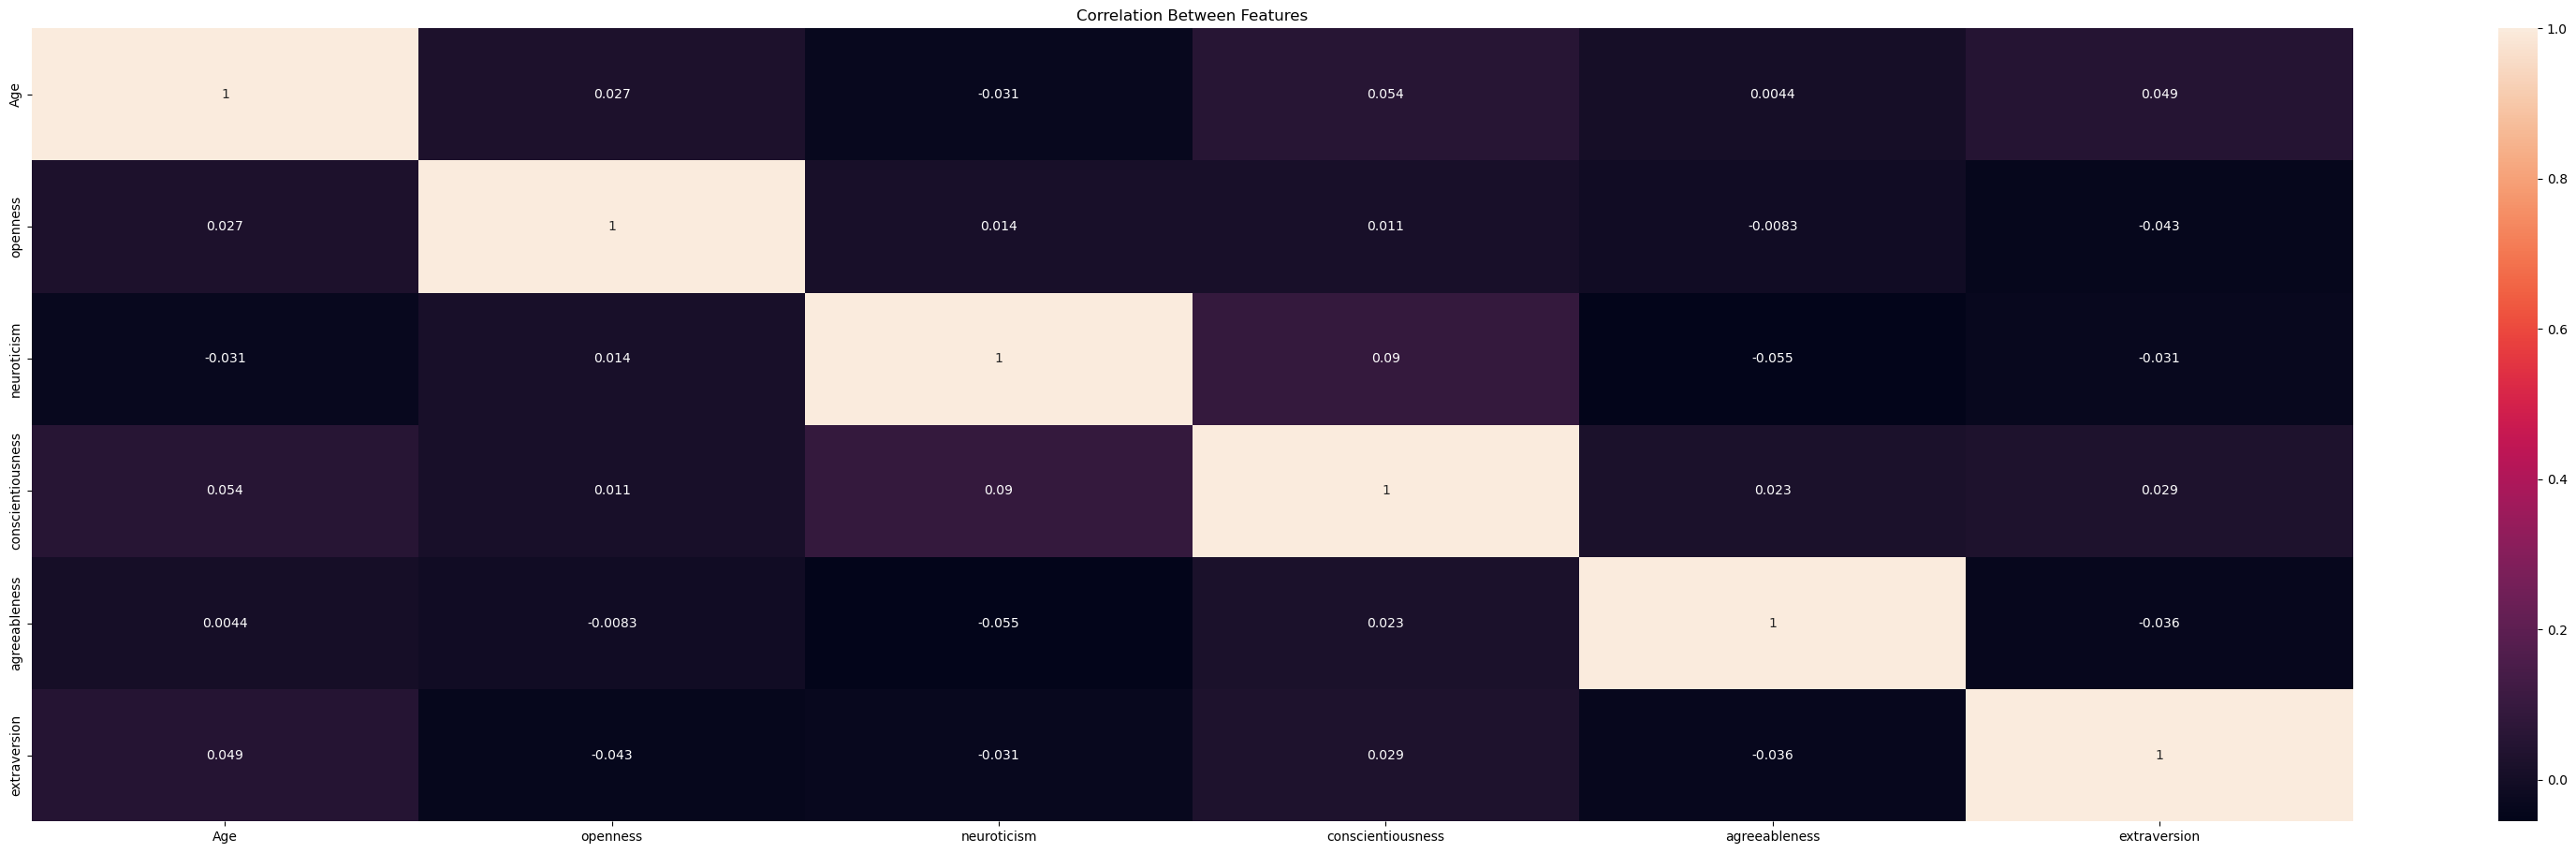

In [9]:
corr = df.corr()
plt.figure(figsize=(40,11))
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True)
plt.title('Correlation Between Features')

In [10]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['int', 'float'])

# **Detecting Outliers if found**

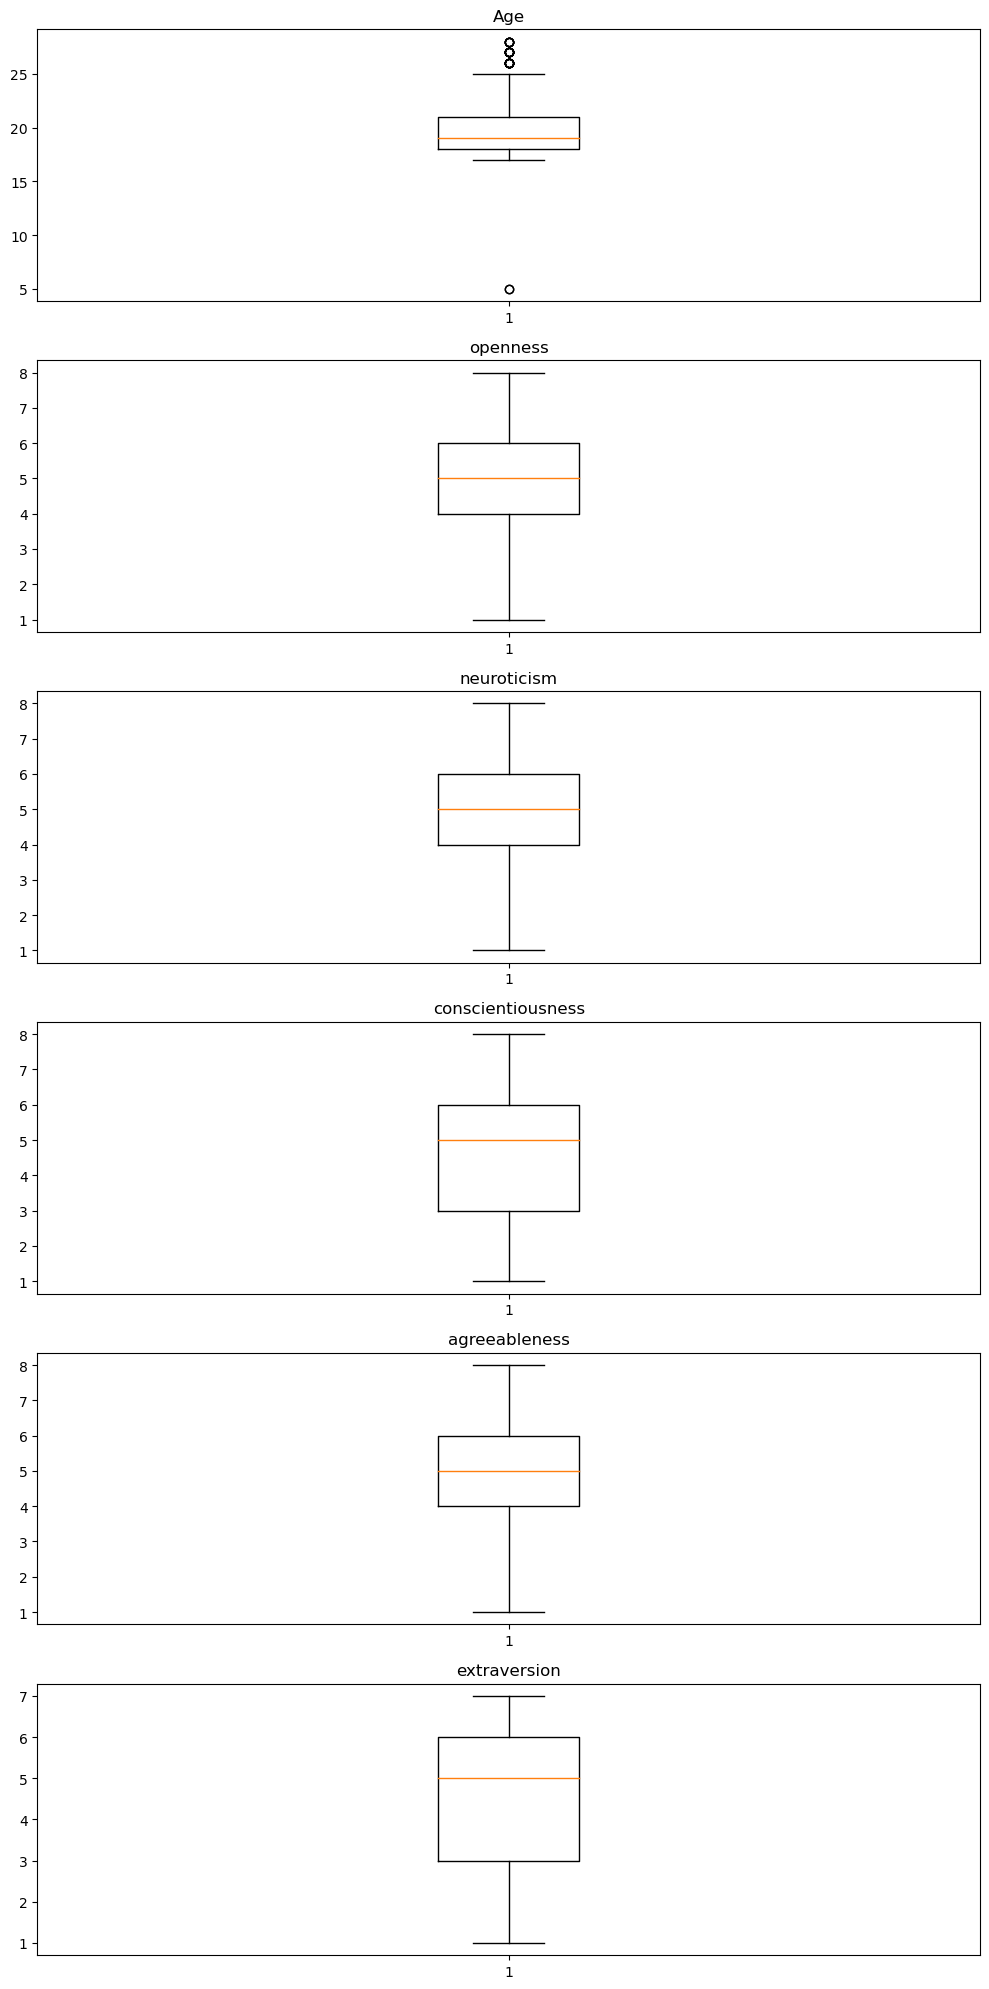

In [11]:
fig, axs = plt.subplots(nrows=len(numeric_cols.columns), figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    axs[i].boxplot(numeric_cols[col])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

It looks like There is no outliers in the Big five traits That awesome!  

In [12]:
df.skew()

Age                  0.672516
openness            -0.654131
neuroticism         -0.486208
conscientiousness   -0.416321
agreeableness       -0.625747
extraversion        -0.327695
dtype: float64

In [13]:
df['openness'] = np.sqrt(max(df['openness']+1) - df['openness'])
df['agreeableness'] = np.sqrt(max(df['agreeableness']+1) - df['agreeableness'])
df.skew()

Age                  0.672516
openness             0.258360
neuroticism         -0.486208
conscientiousness   -0.416321
agreeableness        0.221953
extraversion        -0.327695
dtype: float64

We applied the transformations only to columns with high negative skew below -0.5 to correct their distributions while preserving the shape of columns with normal skew. Normalizing the distribution this way can improve model performance and accuracy.

## **Modeling**

In [14]:
#remove age and geneder as they are not a very important features
df = df.drop(columns=['Gender','Age'])

In [15]:
df['Personality (Class label)'] = df['Personality (Class label)'].map({'dependable':0, 'extraverted':1, 'lively':2, 'responsible':3, 'serious':4})

In [16]:
from sklearn.preprocessing import StandardScaler
X = df.drop('Personality (Class label)', axis=1)
y = df['Personality (Class label)']
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(567, 5) (567,)
(142, 5) (142,)


#### This code is using the SMOTE (Synthetic Minority Oversampling Technique) to resample the training data to address class imbalance.

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)

(630, 5) (630,)


The resampled output is used in place of the original imbalanced data when training models.

[15:56:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Score:  96.03174603174604 %
Test Score:  29.577464788732392 %
Accuracy: 29.577464788732392
------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.29      0.37        31
           1       0.27      0.31      0.29        32
           2       0.27      0.45      0.34        22
           3       0.28      0.23      0.25        22
           4       0.25      0.23      0.24        35

    accuracy                           0.30       142
   macro avg       0.31      0.30      0.30       142
weighted avg       0.32      0.30      0.30       142

------------------------------------------------------------
Confusion matri

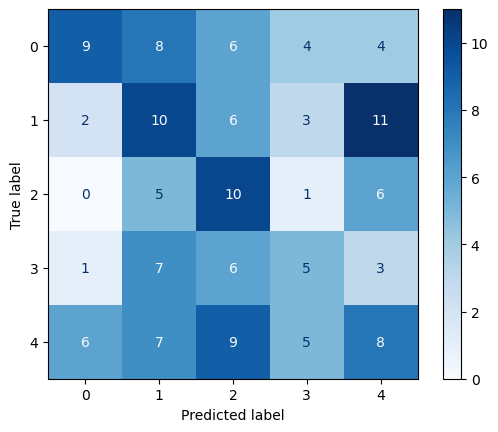

In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

train_score = xgb.score(X_train, y_train)
test_score = xgb.score(X_test, y_test)

print("Train Score: ", train_score*100, "%")
print("Test Score: ", test_score*100, "%")

y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc*100)
print("--"*30)
print("Classification report:\n", report)
print("--"*30)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Train Score:  56.666666666666664 %
Test Score:  23.943661971830984 %
Accuracy: 23.943661971830984
------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.28      0.32      0.30        31
           1       0.23      0.25      0.24        32
           2       0.24      0.36      0.29        22
           3       0.22      0.23      0.22        22
           4       0.20      0.09      0.12        35

    accuracy                           0.24       142
   macro avg       0.23      0.25      0.23       142
weighted avg       0.23      0.24      0.23       142

------------------------------------------------------------
Confusion matrix:
 [[10  8  6  3  4]
 [ 8  8  8  6  2]
 [ 1  6  8  3  4]
 [ 6  3  6  5  2]
 [11 10  5  6  3]]


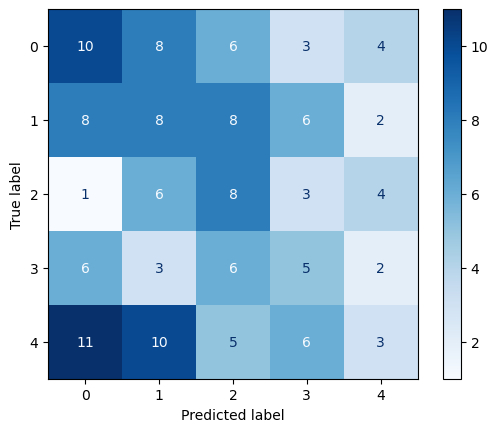

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("Train Score: ", train_score*100, "%")
print("Test Score: ", test_score*100, "%")

y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc*100)
print("--"*30)
print("Classification report:\n", report)
print("--"*30)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Train Score:  96.03174603174604 %
Test Score:  30.985915492957744 %
Accuracy: 30.985915492957744
------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.37      0.23      0.28        31
           1       0.24      0.28      0.26        32
           2       0.31      0.50      0.38        22
           3       0.29      0.18      0.22        22
           4       0.36      0.37      0.37        35

    accuracy                           0.31       142
   macro avg       0.31      0.31      0.30       142
weighted avg       0.32      0.31      0.30       142

------------------------------------------------------------
Confusion matrix:
 [[ 7 11  6  4  3]
 [ 3  9  7  3 10]
 [ 0  3 11  3  5]
 [ 3  5  5  4  5]
 [ 6  9  7  0 13]]


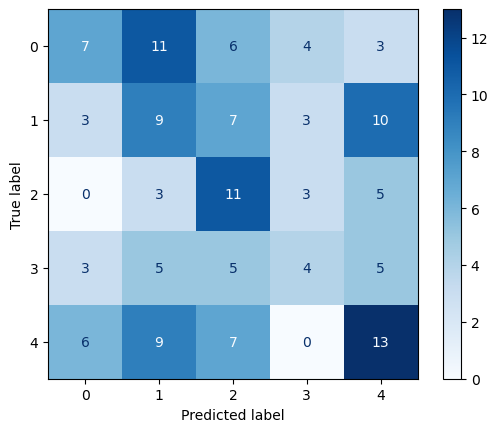

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print("Train Score: ", train_score*100, "%")
print("Test Score: ", test_score*100, "%")

y_pred = rf.predict(X_test)

# Rest of evaluation is same
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc*100)
print("--"*30)
print("Classification report:\n", report)
print("--"*30)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Train Score:  30.952380952380953 %
Test Score:  22.535211267605636 %
Accuracy: 22.535211267605636
------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.21      0.29      0.25        31
           1       0.29      0.31      0.30        32
           2       0.32      0.41      0.36        22
           3       0.11      0.09      0.10        22
           4       0.11      0.06      0.07        35

    accuracy                           0.23       142
   macro avg       0.21      0.23      0.22       142
weighted avg       0.21      0.23      0.21       142

------------------------------------------------------------
Confusion matrix:
 [[ 9  9  5  3  5]
 [ 9 10  4  4  5]
 [ 4  3  9  5  1]
 [ 8  4  2  2  6]
 [12  8  8  5  2]]


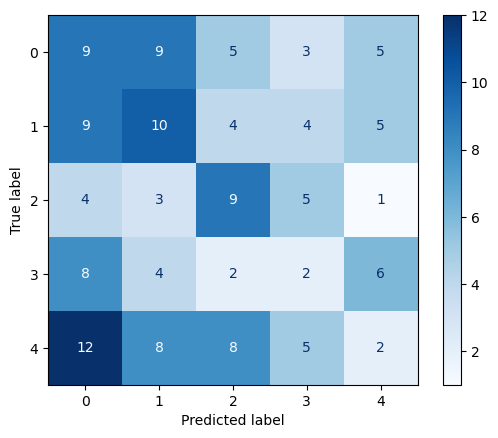

In [21]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train, y_train)

train_score = nb.score(X_train, y_train)
test_score = nb.score(X_test, y_test)

print("Train Score: ", train_score*100, "%")
print("Test Score: ", test_score*100, "%")

y_pred = nb.predict(X_test)

# Rest of evaluation is same
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc*100)
print("--"*30)
print("Classification report:\n", report)
print("--"*30)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Train Score:  25.07936507936508 %
Test Score:  19.014084507042252 %
Accuracy: 19.014084507042252
------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.17      0.19      0.18        31
           1       0.17      0.22      0.19        32
           2       0.31      0.18      0.23        22
           3       0.15      0.18      0.16        22
           4       0.24      0.17      0.20        35

    accuracy                           0.19       142
   macro avg       0.21      0.19      0.19       142
weighted avg       0.20      0.19      0.19       142

------------------------------------------------------------
Confusion matrix:
 [[ 6 11  2  6  6]
 [ 9  7  4  7  5]
 [ 4  6  4  6  2]
 [ 8  3  1  4  6]
 [ 9 14  2  4  6]]


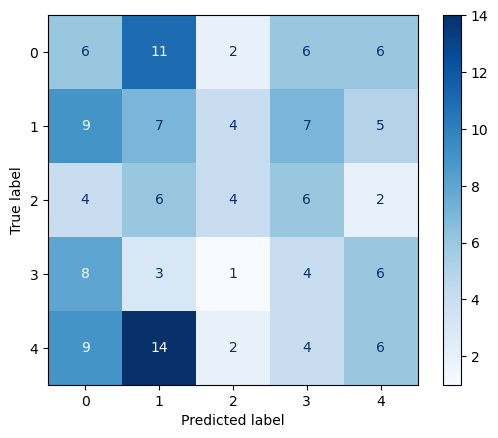

In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print("Train Score: ", train_score*100, "%")
print("Test Score: ", test_score*100, "%")

y_pred = lr.predict(X_test)


acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc*100)
print("--"*30)
print("Classification report:\n", report)
print("--"*30)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1

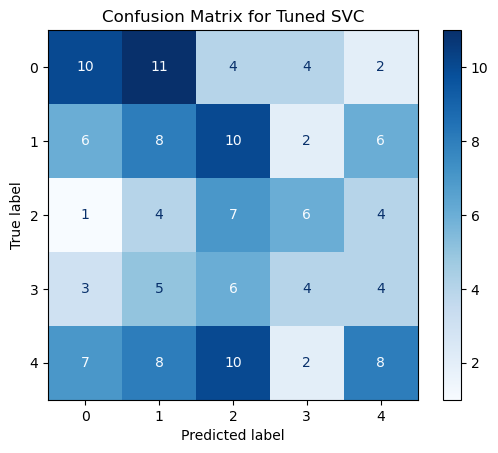

In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

# Define parameter grid
param_grid = {'C': [0.1, 1, 100],
              'gamma': [1, 0.1],
              'kernel': ['rbf', 'sigmoid']}

# K-fold cross validation
cv = StratifiedKFold(n_splits=5)

# Grid Search CV with k-fold Cross Validation
grid = GridSearchCV(SVC(), param_grid, cv=cv, refit=True, verbose=2)

# Fit grid search
grid.fit(X_train, y_train)

# Use best model on test set
best_model = grid.best_estimator_
test_score = best_model.score(X_test, y_test)

print("Tuned SVC Test Score: {:.2f}%".format(test_score*100))

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate predictions
acc = accuracy_score(y_test, y_pred)
print("Tuned SVC Accuracy: {:.2f}%".format(acc*100))

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Tuned SVC")
plt.show()

In [24]:
models = [nb, xgb , rf, best_model , lr]
# Dictionary to store results
results = {}
y_pred_li = []
for model in models:
   y_pred = model.predict(X_test)
   y_pred_li.append(y_pred)
   acc = accuracy_score(y_test, y_pred)
   results[model.__class__.__name__] = acc

## **perform ensambling with all the models available**





In [25]:
from scipy.stats import mode

y_pred_final = [mode(y)[0][0] for y in zip(*y_pred_li)]
accuracy = accuracy_score(y_test, y_pred_final)
results["Ensambling"] = accuracy

# **Another way we are going to try is Stacking and using the outputs of the models to be an input to another model**

In [26]:
X_meta = np.column_stack(y_pred_li)

Train Score:  85.2112676056338 %
Accuracy: 85.2112676056338
------------------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        31
           1       0.82      0.88      0.85        32
           2       0.83      0.91      0.87        22
           3       0.80      0.91      0.85        22
           4       1.00      0.80      0.89        35

    accuracy                           0.85       142
   macro avg       0.85      0.86      0.85       142
weighted avg       0.86      0.85      0.85       142

------------------------------------------------------------
Confusion matrix:
 [[25  3  2  1  0]
 [ 0 28  2  2  0]
 [ 1  1 20  0  0]
 [ 1  1  0 20  0]
 [ 4  1  0  2 28]]


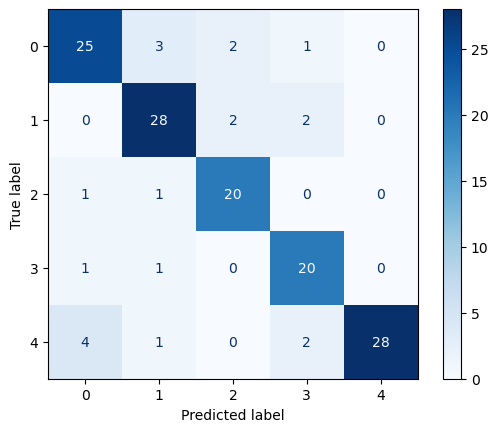

In [27]:
stacked_model = RandomForestClassifier()

stacked_model.fit(X_meta, y_test)

train_score = stacked_model.score(X_meta, y_test)

print("Train Score: ", train_score*100, "%")

y_pred = stacked_model.predict(X_meta)

acc = accuracy_score(y_test, y_pred)
results['Stacked Model'] = acc
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc*100)
print("--"*30)
print("Classification report:\n", report)
print("--"*30)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **Visualization for the accuracy**

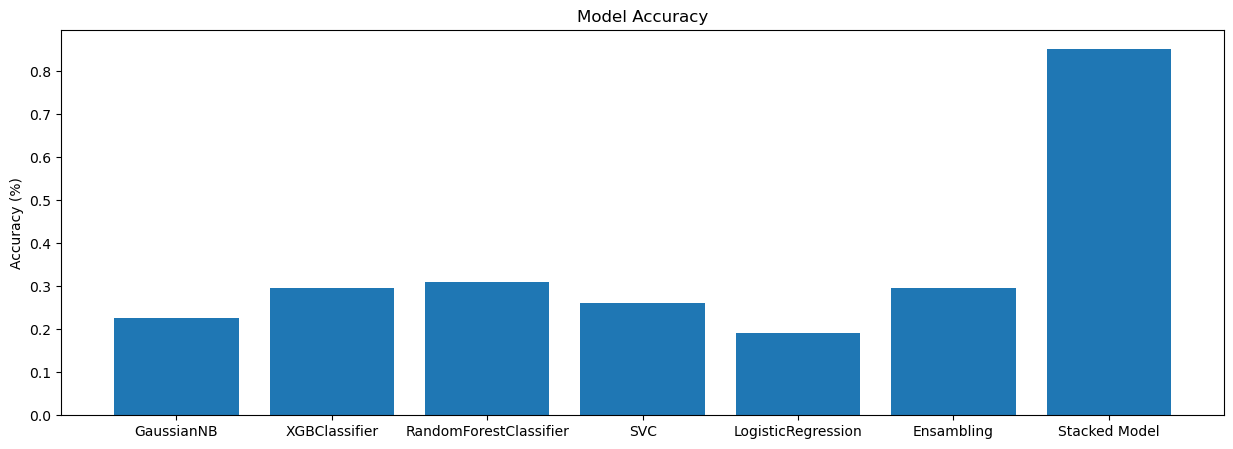

Best model:  Stacked Model


In [28]:
# Plot accuracy as bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.bar(results.keys(), results.values())
plt.title("Model Accuracy")
plt.ylabel("Accuracy (%)")
plt.show()

print("Best model: ", max(results, key=results.get))

# **Testing the Test file**

In [29]:
# Load test data
test_df = pd.read_csv('test.csv')
test_df = test_df.drop(columns=['Gender','Age'])

test_df['Personality (class label)'] = test_df['Personality (class label)'].map({'dependable':0, 'extraverted':1, 'lively':2, 'responsible':3, 'serious':4})
X_test_unseen = test_df.drop('Personality (class label)', axis=1)
X_test_unseen = scaler.transform(X_test_unseen)
y_test_unseen = test_df['Personality (class label)']

In [30]:
models = [nb, xgb , knn, rf, best_model]
# Dictionary to store results
results = {}
y_pred_li = []
for model in models:
   y_pred = model.predict(X_test_unseen)
   y_pred_li.append(y_pred)
   acc = accuracy_score(y_test_unseen, y_pred)
   results[model.__class__.__name__] = acc

In [31]:
y_pred_final = [mode(y)[0][0] for y in zip(*y_pred_li)]
accuracy = accuracy_score(y_test_unseen, y_pred_final)
results["Ensambling"] = accuracy

In [32]:
X_meta = np.column_stack(y_pred_li)

In [33]:
y_pred = stacked_model.predict(X_meta)

acc = accuracy_score(y_test_unseen, y_pred)
results['Stacked Model'] = acc

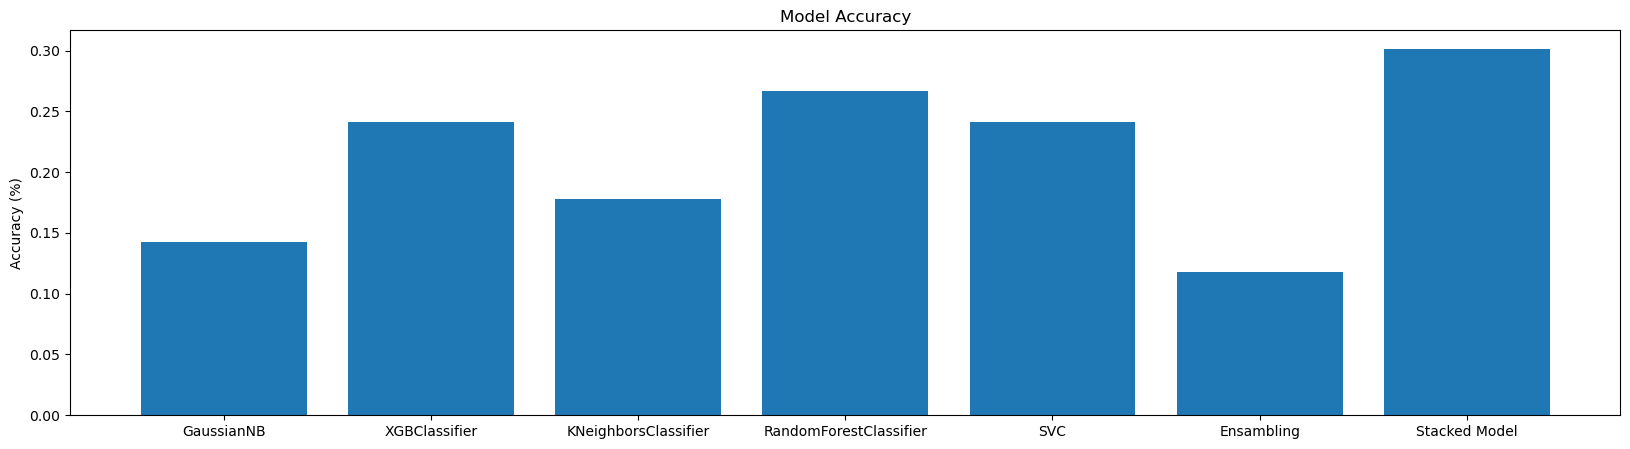

Best model:  Stacked Model


In [34]:
# Plot accuracy as bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.bar(results.keys(), results.values())
plt.title("Model Accuracy")
plt.ylabel("Accuracy (%)")
plt.show()

print("Best model: ", max(results, key=results.get))

After training our model on all of the algorithms, we realised that our predictions turned out to be rather poor. Even best models could only find an accuracy of about 30 percent.

# now reading the csv that we made from Resume_analyser

In [43]:
class ResumeAnalyzer:

    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')

    def load_resume(self, file_path):
        ext = os.path.splitext(file_path)[1].lower()

        if ext == '.pdf':
            pdfFileObj = open(file_path, 'rb')
            pdfReader = PyPDF2.PdfReader(pdfFileObj)
            page = pdfReader.pages[0]
            return page.extract_text()

        elif ext == '.doc' or ext == '.docx':
            return textract.process(file_path).decode('utf-8')

        elif ext == '.txt':
            with open(file_path) as f:
                return f.read()

        else:
            raise Exception("Unsupported file type")

    def process_resume(self, file_path):
        resume_text = self.load_resume(file_path)

        doc = self.nlp(resume_text)

        resume = ResumeParser(file_path).get_extracted_data()
        skills = resume.get('skills')

        work_experience = resume.get('experience')

        name = resume.get('name')
        email = resume.get('email')

        summary = None
        objective = None
        prof_summary = None
        exp_summary = None

        for sent in doc.sents:
            if 'objective' in sent.text.lower():
                objective = sent.text

            if 'summary' in sent.text.lower():
                summary = sent.text

            if 'professional summary' in sent.text.lower() or 'profile' in sent.text.lower():
                prof_summary = sent.text

            if 'experience summary' in sent.text.lower():
                exp_summary = sent.text

        return {
            'name': name,
            'email': email,
            'skills': skills,
            'experience': work_experience,
            'objective': objective,
            'summary': summary,
            'prof_summary': prof_summary,
            'exp_summary': exp_summary,
        }

    def process_folder(self, folder_path, output_file):
        with open(output_file, 'w', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=['name', 'email', 'skills', 'experience', 'objective', 'summary', 'prof_summary', 'exp_summary'])
            writer.writeheader()

            for file in os.listdir(folder_path):
                if file.endswith('.pdf') or file.endswith('.docx'):
                    file_path = os.path.join(folder_path, file)
                    resume_data = self.process_resume(file_path)
                    writer.writerow(resume_data)

In [44]:
analyzer = ResumeAnalyzer()
analyzer.process_folder('C://Users//Ziad Elhady//Personality Prediction System via CV Analysis/Resume','ouptut.csv')

None


# **Now we will read our output csv we made and Extract The important features To get to the model**  

In [47]:
df2 = pd.read_csv('ouptut.csv')

In [48]:
df2.head(50)

,name,email,skills,experience,objective,summary,prof_summary,exp_summary
0,ANUVA GOYAL,anuvagoyal111@gmail.com,"['Html', 'Sql', 'Pytesseract', 'Computer scien...","['Software’s: PyCharm, Jupyter Notebook, Googl...","Female \r\nOBJECTIVE \r\n \r\nEnergetic, i...",NaN,NaN,NaN
1,Name:,abiral.pandey88@gmail.com,"['Html', 'Nosql', 'Sql', 'Pattern', 'Jsp', 'Do...",[],NaN,Visa Status: US Citizen\r\n\r\n\r\n\r\nSUMMARY...,NaN,NaN
2,Achyuth 540,achyuth.java88@gmail.com,"['Banking', 'Mortgage', 'Automation', 'Db2', '...",NaN,achyuth.java88@gmail.com\r\n\r\n\r\n\r\nOBJECT...,PROFESSIONAL SUMMARY:\r\n\r\n\t,PROFESSIONAL SUMMARY:\r\n\r\n\t,NaN
3,Adelina Erimia,erimia@msn.com,"['Branding', 'Green', 'Legal', 'Design', 'Real...",NaN,▪ Developing marketing plan and objectives and...,NaN,NaN,NaN
4,Adhi Gopalam adhigopalam@gmail.com,adhigopalam@gmail.com,"['Banking', 'Automation', 'Auditing', 'Migrati...",NaN,NaN,NaN,NaN,NaN
5,Ajay Kumar,ajaydt@gmail.com,"['Banking', 'Automation', 'Business intelligen...",NaN,Responsible for all SLA (Service Level Agreeme...,Track and prepare the report of testing activi...,"Quality Plan documentation, involved in Projec...",NaN
6,Akhil ...,akhil.mohan0109@gmail.com,"['Banking', 'Green', 'Mock', 'Automation', 'Sd...",NaN,Participated in preparing the project scope an...,Professional Summary:\r\n\r\n,Professional Summary:\r\n\r\n,NaN
7,Akhil ...,akhil.mohan0109@gmail.com,"['Banking', 'Green', 'Mock', 'Automation', 'Sd...",NaN,Participated in preparing the project scope an...,Professional Summary:\r\n\r\n,Professional Summary:\r\n\r\n,NaN
8,Alekhya (,alekhya.workmail@gmail.com,"['Banking', 'Automation', 'Db2', 'Auditing', '...",NaN,NaN,NaN,NaN,NaN
9,Amar Amar.srbsa@gmail.com,Amar.srbsa@gmail.com,"['Banking', 'Financial reporting', 'Mortgage',...",NaN,Self-Motivated and Objective driven profession...,Professional Summary:\r\n\r\n,The project aimed at building software that wo...,NaN


In [49]:
df2 = df2.fillna(' ')

In [50]:
print(spacy.__version__)

2.3.5


**we will treat it as a single coloumn to make it easier for proccessing** 

In [51]:

df2['single'] = df2['name'] + ' ' + df2['email'] + ' ' + df2['skills'] + ' ' + df2['experience'] + df2['objective'] + ' ' + df2['summary'] + ' ' +df2['prof_summary'] + ' ' +df2['exp_summary']


In [52]:
df2.drop(columns=['name' , 'email' ,	'skills',	'experience',	'objective',	'summary' ,	'prof_summary' ,'exp_summary'], inplace=True)

In [53]:
df2.head()

,single
0,"ANUVA GOYAL anuvagoyal111@gmail.com ['Html', '..."
1,"Name: abiral.pandey88@gmail.com ['Html', 'Nosq..."
2,Achyuth 540 achyuth.java88@gmail.com ['Banking...
3,"Adelina Erimia erimia@msn.com ['Branding', 'Gr..."
4,Adhi Gopalam adhigopalam@gmail.com adhigopalam...


In [54]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Ziad
[nltk_data]     Elhady\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ziad
[nltk_data]     Elhady\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ziad
[nltk_data]     Elhady\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ziad
[nltk_data]     Elhady\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Remove Stop words and Clean some mess**

In [55]:
pattern = re.compile(r'(@|#)\w+|[,.]|[()]|https?://\S+|(\?|!)+|\d+')
df2['single'] = df2['single'].apply(lambda text: pattern.sub(' ', text)) \
                                     .apply(lambda text: ' '.join([lemmatizer.lemmatize(word.lower(), 'v') \
                                                                   for word in nltk.word_tokenize(text) \
                                                                   if word.lower() not in stop_words and word.isalpha()]))

In [56]:
df2.head(200)

,single
0,anuva goyal anuvagoyal com science r learn c p...
1,name abiral pandey com science systems skills ...
2,achyuth achyuth java com service r development...
3,adelina erimia erimia com estate report improv...
4,adhi gopalam adhigopalam com adhigopalam com c...
...,...
195,sunitha senior project manager email sruthi co...
196,syed zia ashraf scott com intelligence analysi...
197,accomplish tanmaydam com experience technology...
198,tarun sr business system analyst analysis serv...


**Now we will use spacy to Extract if any various keywords of OCEAN in table below. Each trait is associated with a set of 10 keywords that relate to it. There are many Natural Language Processing (NLP) libraries like Natural Language Toolkit (NLTK), TextBlob, SpaCY which could help us in parsing the resume data. We have used SpaCY- an open-source software library for advanced natural language processing and is helpful to handle large amounts of text data.**

| Trait | Words |
|-|-|
| Openness | imagine, insight, curious, create, outspoken, straightforward, direct, receptive, open-minded, adventurous |
| Conscientiousness | thoughtful, goal, ambitious, organise, mindful, vigilant, control, discipline, reliable, responsible |
| Extraversion | cheerful, sociable, talk, assert, outgoing, energetic, extrovert, friend, enthusiasm, outspoken |  
| Agreeableness | trustworthy, altruism, kind, affection, cooperate, empathize, modest, sympathize, comply, tender-mindedness |
| Neuroticism | calm, strong heart, collect, balance, peace, tranquil, strong-will, emotionally stable, serene, resilient |

In [58]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load('en_core_web_sm')

ocean_traits = {
    'Openness': ['imagine', 'insight', 'curious', 'create', 'outspoken', 'straightforward', 'direct', 'receptive', 'open-minded', 'adventurous'],
    'Conscientiousness': ['thoughtful', 'goal', 'ambitious', 'organise', 'mindful', 'vigilant', 'control', 'discipline', 'reliable', 'responsible'], 
    'Extraversion': ['cheerful', 'sociable', 'talk', 'assert', 'outgoing', 'energetic', 'extrovert', 'friend', 'enthusiasm', 'outspoken'],
    'Agreeableness': ['trustworthy', 'altruism', 'kind', 'affection', 'cooperate', 'empathize', 'modest', 'sympathize', 'comply', 'tender-mindedness'],
    'Neuroticism': ['calm', 'strong heart', 'collect', 'balance', 'peace', 'tranquil', 'strong-will', 'emotionally stable', 'serene', 'resilient']
}

matcher = PhraseMatcher(nlp.vocab)
for trait, keywords in ocean_traits.items():
    patterns = [nlp(text.lower()) for text in keywords]
    matcher.add(trait, None, *patterns)

def assess_traits(text):
    doc = nlp(text.lower())
    scores = {'Openness': 0, 'Conscientiousness': 0, 'Extraversion': 0, 'Agreeableness': 0, 'Neuroticism': 0}
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        trait = nlp.vocab.strings[match_id]
        scores[trait] += 1
    return scores


scores = df2['single'].apply(assess_traits)
print(scores)

0      {'Openness': 0, 'Conscientiousness': 0, 'Extra...
1      {'Openness': 0, 'Conscientiousness': 0, 'Extra...
2      {'Openness': 0, 'Conscientiousness': 0, 'Extra...
3      {'Openness': 0, 'Conscientiousness': 0, 'Extra...
4      {'Openness': 0, 'Conscientiousness': 0, 'Extra...
                             ...                        
224    {'Openness': 0, 'Conscientiousness': 0, 'Extra...
225    {'Openness': 0, 'Conscientiousness': 0, 'Extra...
226    {'Openness': 0, 'Conscientiousness': 0, 'Extra...
227    {'Openness': 0, 'Conscientiousness': 0, 'Extra...
228    {'Openness': 1, 'Conscientiousness': 0, 'Extra...
Name: single, Length: 229, dtype: object


In [59]:
personality_map = {0: 'dependable', 1: 'extraverted', 2: 'lively',
                   3: 'responsible', 4: 'serious'}

In [60]:
for score in scores:
    x = [score['Openness'], score['Conscientiousness'], score['Extraversion'],
         score['Agreeableness'], score['Neuroticism']]
    y_pred = rf.predict([x])[0]
    score['Personality (Class label)'] = personality_map[y_pred]

In [61]:
with open('ocean_scores.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Openness', 'Conscientiousness', 'Extraversion',
                     'Agreeableness', 'Neuroticism', 'Personality (Class label)'])
    for score in scores:
        writer.writerow([score['Openness'], score['Conscientiousness'], score['Extraversion'],
                         score['Agreeableness'], score['Neuroticism'],
                         score['Personality (Class label)']])

In [67]:
import tkinter as tk
from tkinter import *
import tkinter.font as font

def test(test_data):
    try:
        test_predict=list()
        for i in test_data:
            test_predict.append(int(i))
        y_pred = rf.predict([test_predict])
        print(y_pred[0])
        return y_pred[0]
    except:
        print("All Factors For Finding Personality Not Entered!")

def upload_cv():
    
    top = tk.Toplevel()
    top.title("Upload CV")
    top.geometry("500x300")
    top.configure(background='black')


    # Add an upload button
    upload_button = tk.Button(top, text="Upload CV", command=lambda: upload_cv_file(top))
    upload_button.pack(pady=20)
    upload_button.place(relx=0.5, rely=0.5, anchor="center")

def enter_big_five_traits():
    # Open a new window to enter the big five traits
    top = tk.Toplevel()
    top.title("Enter Big Five Traits")
    top.configure(background='black')
    top.geometry("500x300")

    l1=Label(top, text="Applicant Name", foreground='white', bg='black').place(x=70, y=130)
    l2=Label(top, text="Age", foreground='white', bg='black').place(x=70, y=160)
    l3=Label(top, text="Gender", foreground='white', bg='black').place(x=70, y=190)
    l5=Label(top, text="Enjoy New Experience or thing(Openness)", foreground='white', bg='black').place(x=70, y=250)
    l6=Label(top, text="How Offen You Feel Negativity(Neuroticism)", foreground='white', bg='black').place(x=70, y=280)
    l7=Label(top, text="Wishing to do one's work well and thoroughly(Conscientiousness)", foreground='white', bg='black').place(x=70, y=310)
    l8=Label(top, text="How much would you like work with your peers(Agreeableness)", foreground='white', bg='black').place(x=70, y=340)
    l9=Label(top, text="How outgoing and social interaction you like(Extraversion)", foreground='white', bg='black').place(x=70, y=370)
    
    sName=Entry(top)
    sName.place(x=450, y=130, width=160)
    age=Entry(top)
    age.place(x=450, y=160, width=160)
    gender = IntVar()
    R1 = Radiobutton(top, text="Male", variable=gender, value=1, padx=7)
    R1.place(x=450, y=190)
    R2 = Radiobutton(top, text="Female", variable=gender, value=0, padx=3)
    R2.place(x=540, y=190)
    openness=Entry(top)
    openness.insert(0,'1-10')
    openness.place(x=450, y=250, width=160)
    neuroticism=Entry(top)
    neuroticism.insert(0,'1-10')
    neuroticism.place(x=450, y=280, width=160)
    conscientiousness=Entry(top)
    conscientiousness.insert(0,'1-10')
    conscientiousness.place(x=450, y=310, width=160)
    agreeableness=Entry(top)
    agreeableness.insert(0,'1-10')
    agreeableness.place(x=450, y=340, width=160)
    extraversion=Entry(top)
    extraversion.insert(0,'1-10')
    extraversion.place(x=450, y=370, width=160)
    # Add a calculate button
    submitBtn=Button(top, padx=2, pady=0, text="Submit", bd=0, foreground='white', bg='red', font=(12))
    submitBtn.config(command=lambda: prediction_result(top,sName,(gender.get(),age.get(),openness.get(),neuroticism.get(),conscientiousness.get(),agreeableness.get(),extraversion.get())))
    submitBtn.place(x=350, y=400, width=200)
    
    
def upload_cv_file(top):
    
    filename = tk.filedialog.askopenfilename(filetypes=[("CV files", "*.pdf")])
    resume = ResumeAnalyzer()
    parsed = resume.process_resume(filename)
    submitBtn=Button(top, padx=2, pady=0, text="Submit", bd=0, foreground='white', bg='red', font=(12))
    submitBtn.config(command=lambda: prediction_result_CV(parsed,top))
    submitBtn.pack(pady=20)
    submitBtn.place(relx=0.5, rely=0.6, anchor="center") 
   
def prediction_result_CV(parsed,top):
    
    df = pd.DataFrame([parsed])
    # Fill null values with spaces
    df = df.fillna(' ')

    # Concatenate all columns into one
    df['parsed'] = df.astype(str).agg(' '.join, axis=1) 
    df = df[['parsed']] 
    df['parsed'] = df['parsed'].apply(lambda text: pattern.sub(' ', text)) \
                                     .apply(lambda text: ' '.join([lemmatizer.lemmatize(word.lower(), 'v') \
                                                                   for word in nltk.word_tokenize(text) \
                                                                   if word.lower() not in stop_words and word.isalpha()]))
    score = df['parsed'].apply(assess_traits)
    for score in scores:
        x = [score['Openness'], score['Conscientiousness'], score['Extraversion'],
             score['Agreeableness'], score['Neuroticism']]
    y_pred = rf.predict([x])[0]
    personality = personality_map[y_pred]
    top.withdraw()
    result=Tk()
    result.overrideredirect(False)
    result.geometry("{0}x{1}+0+0".format(result.winfo_screenwidth(), result.winfo_screenheight()))
    result.configure(background='White')
    result.title("Predicted Personality")
    titleFont = font.Font(family='Arial', size=40, weight='bold')
    Label(result, text="Result - Personality Prediction", foreground='green', bg='white', font=titleFont, pady=10, anchor=CENTER).pack(fill=BOTH)
    
    Label(result, text = str('{} : {}'.format("Name:", parsed['name'])).title(), foreground='black', bg='white', anchor='w').pack(fill=BOTH)
    Label(result, text = str("perdicted personality: "+ personality).title(), foreground='black', bg='white', anchor='w').pack(fill=BOTH)
    
    quitBtn = Button(result, text="Exit", command =lambda:  result.destroy()).pack()

    result.mainloop()
    
    
def prediction_result(top, aplcnt_name, personality_values):
    "after applying a job"
    top.withdraw()
    applicant_data={"Candidate Name":aplcnt_name.get()}
    
    age = personality_values[1]
    
    personality = test(personality_values[2:]).item()
    personality = personality_map[personality]
    result=Tk()
    result.overrideredirect(False)
    result.geometry("{0}x{1}+0+0".format(result.winfo_screenwidth(), result.winfo_screenheight()))
    result.configure(background='White')
    result.title("Predicted Personality")
    
    titleFont = font.Font(family='Arial', size=40, weight='bold')
    Label(result, text="Result - Personality Prediction", foreground='green', bg='white', font=titleFont, pady=10, anchor=CENTER).pack(fill=BOTH)
    
    Label(result, text = str('{} : {}'.format("Name:", aplcnt_name.get())).title(), foreground='black', bg='white', anchor='w').pack(fill=BOTH)
    Label(result, text = str('{} : {}'.format("Age:", age)), foreground='black', bg='white', anchor='w').pack(fill=BOTH)
    Label(result, text = str("perdicted personality: "+ personality).title(), foreground='black', bg='white', anchor='w').pack(fill=BOTH)
    
    quitBtn = Button(result, text="Exit", command =lambda:  result.destroy()).pack()

    result.mainloop()


if __name__ == "__main__":

    root = tk.Tk()
    root.title('Personality Prediction System')
    root.geometry("500x300")

    # Add title
    title_label = tk.Label(root, text="Personality Prediction", font=("Arial", 18))
    title_label.pack()

    # Frame and Buttons
    button_frame = tk.Frame(root)
    button_frame.pack(pady=20)

    button_frame.columnconfigure(0, weight=1) 
    button_frame.columnconfigure(1, weight=1)

    upload_button = tk.Button(button_frame, text="Upload CV" , command = upload_cv)
    upload_button.grid(row=0, column=0, sticky="ew")

    enter_big_five_traits_button = tk.Button(button_frame, text="Enter Big Five Traits",command = enter_big_five_traits) 
    enter_big_five_traits_button.grid(row=0, column=1, sticky="ew")

    button_frame.grid_columnconfigure(0, weight=1)
    button_frame.grid_columnconfigure(1, weight=1)

    root.mainloop()